In [34]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio
from scipy import signal
from scipy.optimize import curve_fit
from qutip import *
from scipy.signal import find_peaks


In [13]:
# Open data file
data = sio.loadmat(r"\\nyx.caltech.edu\painter\LabberData_DF5\QM_Data_DF5\2023\08\Data_0818\UA_Q2_RR_spec_flux_sweep_0818-1703.mat")

array([[7.12610e+09, 7.12615e+09, 7.12620e+09, 7.12625e+09, 7.12630e+09,
        7.12635e+09, 7.12640e+09, 7.12645e+09, 7.12650e+09, 7.12655e+09,
        7.12660e+09, 7.12665e+09, 7.12670e+09, 7.12675e+09, 7.12680e+09,
        7.12685e+09, 7.12690e+09, 7.12695e+09, 7.12700e+09, 7.12705e+09,
        7.12710e+09, 7.12715e+09, 7.12720e+09, 7.12725e+09, 7.12730e+09,
        7.12735e+09, 7.12740e+09, 7.12745e+09, 7.12750e+09, 7.12755e+09,
        7.12760e+09, 7.12765e+09, 7.12770e+09, 7.12775e+09, 7.12780e+09,
        7.12785e+09, 7.12790e+09, 7.12795e+09, 7.12800e+09, 7.12805e+09,
        7.12810e+09, 7.12815e+09, 7.12820e+09, 7.12825e+09, 7.12830e+09,
        7.12835e+09, 7.12840e+09, 7.12845e+09, 7.12850e+09, 7.12855e+09,
        7.12860e+09, 7.12865e+09, 7.12870e+09, 7.12875e+09, 7.12880e+09,
        7.12885e+09, 7.12890e+09, 7.12895e+09, 7.12900e+09, 7.12905e+09,
        7.12910e+09, 7.12915e+09, 7.12920e+09, 7.12925e+09, 7.12930e+09,
        7.12935e+09, 7.12940e+09, 7.12945e+09, 7.12

In [11]:
def Phi_flux_RR(flux, c, phi0):
    # Argument for the cosine flux tuning curve
    return 2*np.pi*c*flux + phi0

def ham(flux, out, wr, Ec, Ej, c, phi0, g):
    # Hamiltonian function
    # The flux is the independent variable
    # The following are fitting parameters: wr, Ec, Ej, c, phi0, g
    # The output is the resonator frequency for all the input flux values
    # The output frequency array is in units of MHz

    N = 4 # 0-3 photons

    a = tensor(destroy(N), qeye(N)) # cavity mode
    b = tensor(qeye(N), destroy(N)) # qubit

    f_ham = []

    # Hamiltonian as a function of flux
    for k in range(np.size(flux)):
        H = wr*a.dag()*a + (np.sqrt(8*Ec*Ej*np.abs(np.cos(Phi_flux_RR(flux[0][k],c, phi0))))-Ec)*b.dag()*b - Ec/2*b.dag()*b.dag()*b*b + g*(a*b.dag()+a.dag()*b)
        w, v = np.linalg.eig(H)
        
        for n_1 in range(v.shape[1]):
            v[:,n_1] = v[:,n_1]/np.inner(v[:,n_1],v[:,n_1])

            idx_00 = np.argmax(np.abs(v[0,:])) # |0,0>
            idx_01 = np.argmax(np.abs(v[N,:])) # |1,0> photon
            idx_02 = np.argmax(np.abs(v[1,:])) # |0,1> qubit
        match out:
                case 1:
                    f_ham.append(np.abs(np.maximum(w[idx_01],w[idx_02]) - w[idx_00]))
                case 2:
                    f_ham.append(np.abs(np.minimum(w[idx_01],w[idx_02]) - w[idx_00]))
    f_ham = np.array(f_ham)
    return f_ham

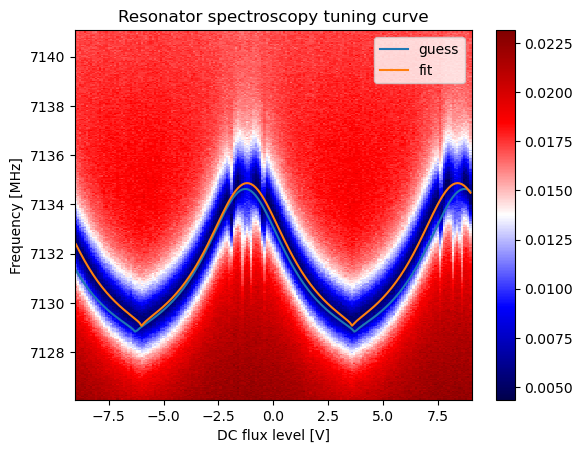

In [15]:
# This plots the result of the RR tuning curve as well as the fitting using the Hamiltonian

# Initial guess
wr = 7128 # Resonator frequency
Ec = 170.080 # Capacitive energy
Ej = 30642.9 # Inductive energy 
c = 0.05 # Period in cosine function for flux
phi0 = 0.4 # Offset in cosine function for flux
g = 74.965 # RR-qubit coupling

# Load data
freq = data['RR_freq']
flux = data['dc_flux_sweep']
sig = data['sig']
phase = data['sig_phase']
sig = np.reshape(sig, (np.size(flux), np.size(freq)))
phase = np.reshape(phase, (np.size(flux), np.size(freq)))

fig = plt.figure()
plt.rcParams['figure.figsize'] = [12, 8]
plt.cla()

# 2D spectroscopy plot
plt.title("Resonator spectroscopy tuning curve")
plt.pcolormesh( np.linspace(np.min(flux), np.max(flux), np.size(flux)),np.linspace(np.min(freq), np.max(freq), np.size(freq))/1e6, sig.T, shading="nearest", cmap="seismic")
plt.xlabel("DC flux level [V]")
plt.ylabel("Frequency [MHz]")
plt.colorbar()

# Array of initial guess
guess = [wr, Ec, Ej, c, phi0, g]

# Frequency output from hamiltonian function using initial guess
freq_fit_guess = ham(flux, 1, *guess)

# Plot of initial guess
plt.plot(flux.T, freq_fit_guess)

# Determine minima of signal to use as ydata for fitting
minimas = []
min_sig = []
for i in range(np.size(flux)):
    minimas.append(freq[0][np.argmin(sig[i])])
minimas = np.array(minimas)
min_sig = np.array(min_sig)

## Plot minima of signal
# plt.scatter(flux.T, minimas/1e6)

minimas_mhz = minimas/1e6

# Fit data from minima of signal to Hamiltonian function
# Initial guess is given by p0
# Bounds are necessary. The order is bounds = ((min_wr, min_Ec, min_Ej, min_c, min_phi0, min_g), (max_wr, max_Ec, max_Ej, max_c, max_phi0, max_g))
popt, _ = curve_fit(lambda flux, *guess: ham(flux, 1, *guess), xdata = flux, ydata = minimas_mhz, p0=guess, check_finite = "true", bounds = ((wr-200, Ec-100, Ej-20000, 0.0001, -4, g-50),(wr+200, Ec+100 ,Ej+ 20000, 4, 4, g+50)))

# This is the frequency output from the fitted data
freq_fit = ham(flux, 1, *popt)

# Plot the fitted data
plt.plot(flux.T, freq_fit)

plt.legend(["guess", "fit"])
plt.show()

Text(0, 0.5, 'Frequency [MHz]')

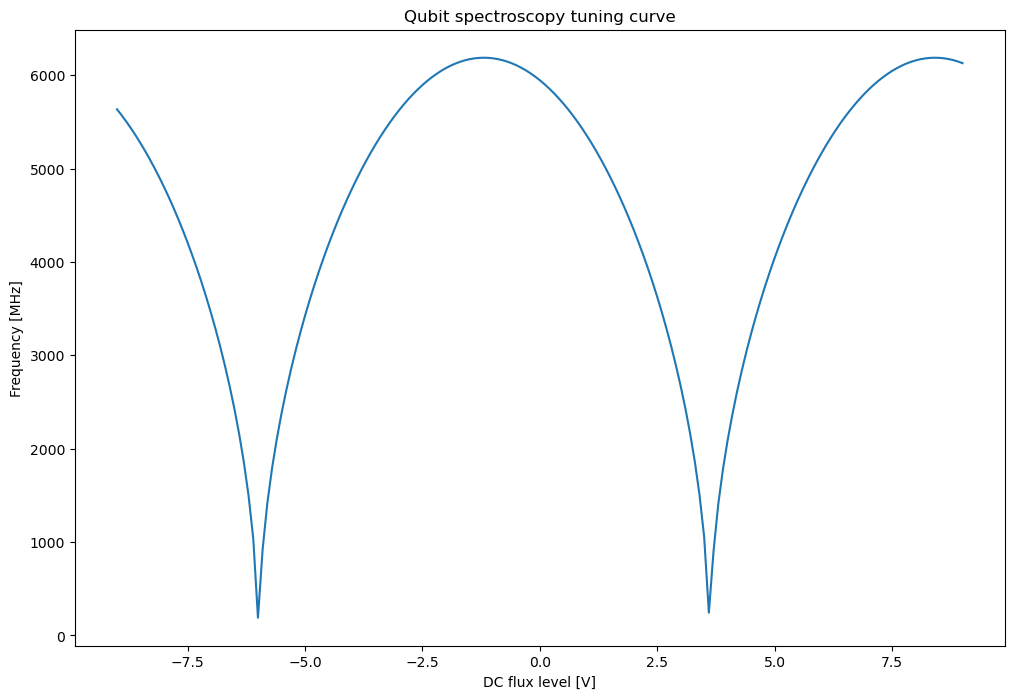

In [105]:
# Fitted ESR plot
freq_fit_qubit = ham(flux, 2, *popt)

plt.title("Qubit spectroscopy tuning curve")
plt.plot(flux.T, freq_fit_qubit)
plt.xlabel("DC flux level [V]")
plt.ylabel("Frequency [MHz]")

In [112]:
# Find SS using a specified resolution
# Make sure that the interval is small for the chosen resolution so that it not takes forever
flux_lb = -1.5
flux_ub = -1
resol = 0.001
flux_int = [np.arange(flux_lb, flux_ub, resol)]
freq_fit_qubit_SS = ham(flux_int, 2, *popt)
prec = len(str(resol).split(".")[1]) # precision based from reoslution
SS = flux_int[0][np.argmax(freq_fit_qubit_SS)]
print("Sweet spot: %.*f V" % (prec, SS))


# # Find SS from a reduced matrix using the same resolution as the original flux array
# flux_red = []
# for i in np.arange(0, np.size(flux), 1):
#     if flux[0][i] >= flux_lb and flux[0][i] <= flux_ub:
#         flux_red.append(flux[0][i])
#     else:
#         pass
# flux_red = [flux_red]
# freq_fit_qubit_SS = ham(flux_red, 2, *popt)
# SS = flux_red[0][np.argmax(freq_fit_qubit_SS)]



Sweet spot: -1.189 V


qubit parameters a*(flux+b)^2+c... 

a = -174.617

b = 1.188759

c = 6191.2



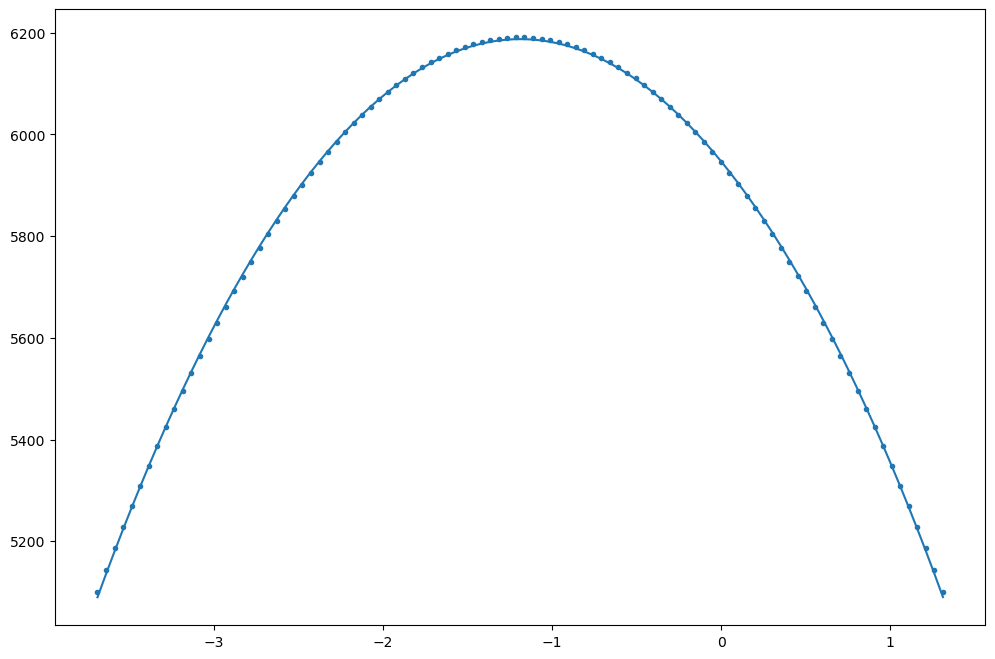

In [134]:
# Fit ESR to a parabola
num_steps = 100
x_fit = np.array([np.linspace(SS - 2.5,SS + 2.5,num_steps)])
y_fit = ham(x_fit, 2, *popt)
plt.plot(x_fit.T, y_fit)

# Fit to polynomial
Q_fit_p2 = np.polyfit(x_fit[0], y_fit, 2)
plt.scatter(x_fit[0], np.polyval(Q_fit_p2, x_fit).T, marker =".")
print('qubit parameters a*(flux+b)^2+c... \n')
b = Q_fit_p2[1]/2/Q_fit_p2[0]
c = np.polyval(Q_fit_p2,-Q_fit_p2[1]/2/Q_fit_p2[0])

print('a = %.3f\n' % Q_fit_p2[0])
print('b = %.6f\n' % b)
print('c = %.1f\n' % c)



def freq_wq(flux):
    return -169.011 * (flux + 1.164205)**2 + 6295.6
    #return -5.52 * flux**4 - 20.322 * flux**3 - 291.868 * flux**2 - 497.137 * flux + 6354.068